# Egypt Population Prediction 2016_2030
### This project aims to predict the population of Egypt for the period (2016-2030), using the data downloaded from www.data.world of the Global Health & Nutrition data. The data cleaning part was done using Microsoft Excel

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
raw_data = pd.read_csv('datasets/egypt_data.csv')
df = raw_data.copy()
df.date = pd.to_datetime(df.date, dayfirst = True)
df.set_index("date", inplace = True)
df = df.asfreq("a")
df.tail()

,female_popultion,male_population,total_population
date,,,
2011-12-31,41488021,42299613,83787634
2012-12-31,42403053,43257849,85660902
2013-12-31,43358108,44255801,87613909
2014-12-31,44321011,45258659,89579670
2015-12-31,45267664,46240420,91508084


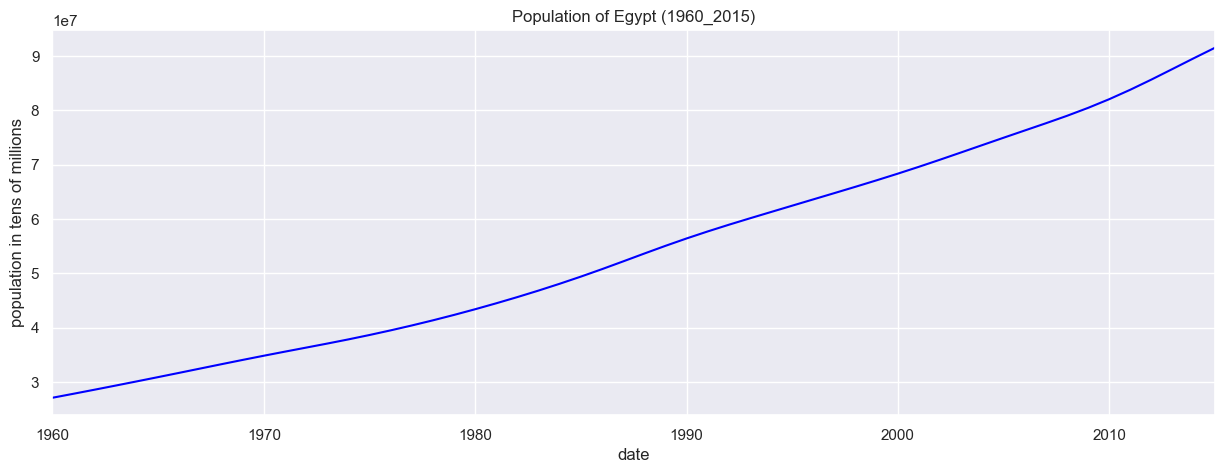

In [3]:
df.total_population.plot(color = "blue",figsize = (15,5),ylabel = "population in tens of millions")
plt.title("Population of Egypt (1960_2015)")
plt.show()

## Stationarity Test
We can't make predictions on a time series unless the time series is stationary. Fortunately, the Augmented Dickey_fuller test Provides a way to test stationarity.

In [4]:
from statsmodels.tsa.stattools import adfuller

adfuller(df.total_population)

(3.3927585735712635,
 1.0,
 11,
 44,
 {'1%': -3.5885733964124715,
  '5%': -2.929885661157025,
  '10%': -2.6031845661157025},
 904.045261645351)

Oops! Those are bad numbers, the data is not statioary. Maybe if we differenced the data a couple of times, we will reach stationarity.

## Differencing the Population

In [5]:
df["diff_ttl_pop_1"] = df.total_population.diff()
df["diff_ttl_pop_2"] = df.diff_ttl_pop_1.diff()
df["diff_ttl_pop_3"] = df.diff_ttl_pop_2.diff()
df.head()

,female_popultion,male_population,total_population,diff_ttl_pop_1,diff_ttl_pop_2,diff_ttl_pop_3
date,,,,,,
1960-12-31,13362000,13710397,27072397,NaN,NaN,NaN
1961-12-31,13722335,14087666,27810001,737604.0,NaN,NaN
1962-12-31,14089004,14471737,28560741,750740.0,13136.0,NaN
1963-12-31,14461633,14861076,29322709,761968.0,11228.0,-1908.0
1964-12-31,14840107,15253975,30094082,771373.0,9405.0,-1823.0


In [6]:
# Testing Stationarity of the first level differenced population
adfuller(df.diff_ttl_pop_1[1:])

(-0.7197911290414176,
 0.8415563750089979,
 8,
 46,
 {'1%': -3.5812576580093696,
  '5%': -2.9267849124681518,
  '10%': -2.6015409829867675},
 894.1572673439466)

In [7]:
# Testing Stationarity of the second level differenced population
adfuller(df.diff_ttl_pop_2[2:])

(-2.1326883254180236,
 0.23157517347478007,
 7,
 46,
 {'1%': -3.5812576580093696,
  '5%': -2.9267849124681518,
  '10%': -2.6015409829867675},
 873.5798653340403)

In [8]:
# Testing Stationarity of the third level differenced population
adfuller(df.diff_ttl_pop_3[3:])

(-3.2119998054699845,
 0.019300506189493933,
 6,
 46,
 {'1%': -3.5812576580093696,
  '5%': -2.9267849124681518,
  '10%': -2.6015409829867675},
 856.7399683257335)

That's it. The test assures the stationarity of the third level Differenced popultion, this is the column we will use to make predictions, but first, let's take a look at it.

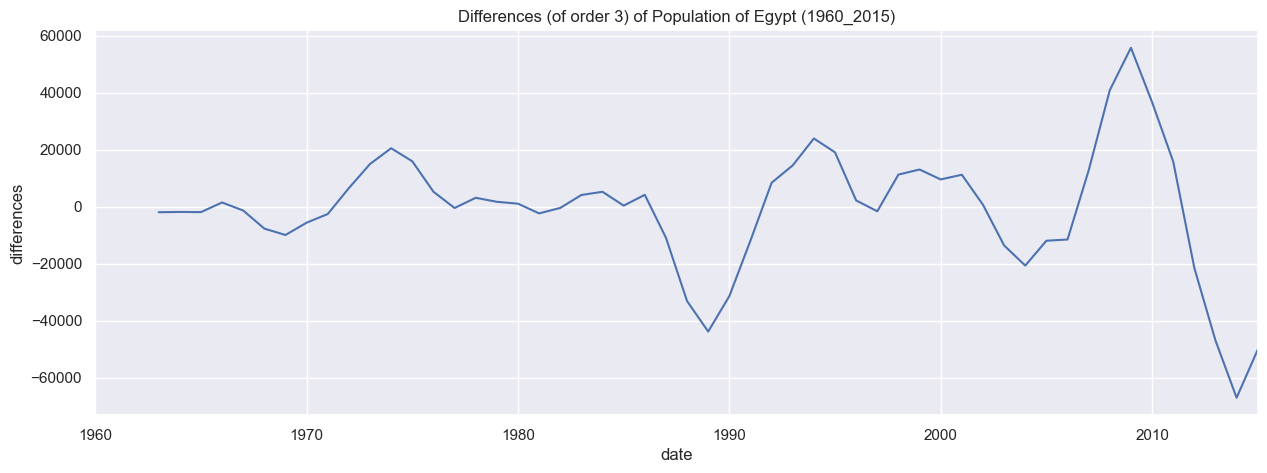

In [9]:
df.diff_ttl_pop_3.plot(figsize = (15,5),ylabel = "differences", label = "diff")
plt.title("Differences (of order 3) of Population of Egypt (1960_2015)")
plt.show()

## Searching the best model
The Auto_arima model runs various Arima models and gives back the best optimized parameters the best work with the data.

In [10]:
from pmdarima.arima import auto_arima

auto_model = auto_arima(df.diff_ttl_pop_3[3:])
auto_model
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   53
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -550.806
Date:                Sat, 03 Dec 2022   AIC                           1107.612
Time:                        21:17:23   BIC                           1113.522
Sample:                    12-31-1963   HQIC                          1109.885
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4517      0.072     20.093      0.000       1.310       1.593
ar.L2         -0.8360      0.084     -9.983      0.000      -1.000      -0.672
sigma2      6.035e+07   2.85e-10   2.12e+17      0.000    6.04e+07    6.04e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.53   Prob(JB):                         1.00
Heteroskedasticity (H):               8.10   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.62e+33. Standard errors may be unstable.
"""

### The output model is SARIMAX(2, 0, 0) Which is equivalent to ARIMA(2, 0, 0) or AR(2).

## Train_Test splitting

In [11]:
train = df.iloc[:50]
test = df.iloc[50:]

In [12]:
train.tail()

,female_popultion,male_population,total_population,diff_ttl_pop_1,diff_ttl_pop_2,diff_ttl_pop_3
date,,,,,,
2005-12-31,37180097,37762018,74942115,1346047.0,-2395.0,-11921.0
2006-12-31,37825860,38448425,76274285,1332170.0,-13877.0,-11482.0
2007-12-31,38472775,39132552,77605327,1331042.0,-1128.0,12749.0
2008-12-31,39140493,39835629,78976122,1370795.0,39753.0,40881.0
2009-12-31,39855576,40586867,80442443,1466321.0,95526.0,55773.0


In [13]:
test.head()

,female_popultion,male_population,total_population,diff_ttl_pop_1,diff_ttl_pop_2,diff_ttl_pop_3
date,,,,,,
2010-12-31,40635503,41405491,82040994,1598551.0,132230.0,36704.0
2011-12-31,41488021,42299613,83787634,1746640.0,148089.0,15859.0
2012-12-31,42403053,43257849,85660902,1873268.0,126628.0,-21461.0
2013-12-31,43358108,44255801,87613909,1953007.0,79739.0,-46889.0
2014-12-31,44321011,45258659,89579670,1965761.0,12754.0,-66985.0


## Applying The model

In [14]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df.diff_ttl_pop_3[3:], order = (2,0,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         diff_ttl_pop_3   No. Observations:                   53
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -550.903
Date:                Sat, 03 Dec 2022   AIC                           1109.806
Time:                        21:17:30   BIC                           1117.687
Sample:                    12-31-1963   HQIC                          1112.837
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -952.5093   2930.732     -0.325      0.745   -6696.639    4791.620
ar.L1          1.4501      0.075     19.416      0.000       1.304       1.596
ar.L2         -0.8321      0.086     -9.636      0.000      -1.001      -0.663
sigma2      6.064e+07      0.106   5.73e+08      0.000    6.06e+07    6.06e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.55   Prob(JB):                         1.00
Heteroskedasticity (H):               7.78   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.22e+24. Standard errors may be unstable.
"""

### Let's see how the model works on the training data

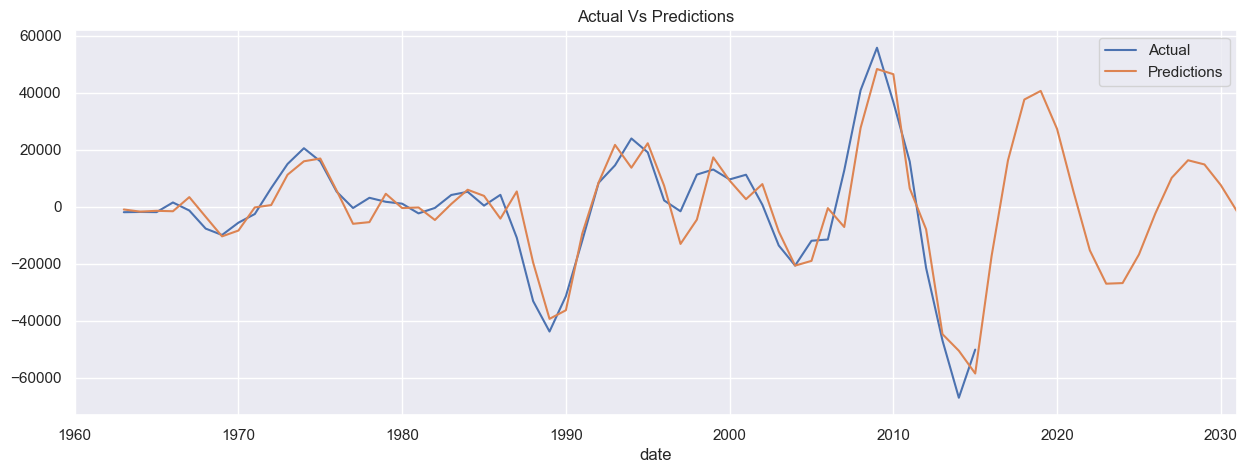

In [15]:
predictions = results.predict(start = '1963-12-31', end = '2031-12-31')

df.diff_ttl_pop_3.plot(label = "Actual")
predictions.plot(figsize = (15,5), label = "Predictions")

plt.title("Actual Vs Predictions")

plt.legend()

In [16]:
predictions = predictions[-17:]
predictions

2015-12-31   -58480.197338
2016-12-31   -17275.237602
2017-12-31    16275.126141
2018-12-31    37610.986015
2019-12-31    40632.023979
2020-12-31    27259.054927
2021-12-31     5353.500970
2022-12-31   -15283.351307
2023-12-31   -26980.488521
2024-12-31   -26770.112724
2025-12-31   -16731.802589
2026-12-31    -2350.611931
2027-12-31    10150.179603
2028-12-31    16310.527878
2029-12-31    14841.484153
2030-12-31     7585.210067
2031-12-31    -1714.491148
Freq: A-DEC, Name: predicted_mean, dtype: float64

In [17]:
k = len(predictions)

df_predicted = pd.DataFrame({'date' : np.arange(k),
                             'total_population' : np.arange(k),
                             'diff_ttl_pop_1' : np.arange(k),
                             'diff_ttl_pop_2' : np.arange(k),
                             'diff_ttl_pop_3' : np.arange(k)},
                             dtype="float64")

df_predicted.set_index(predictions.index, inplace = True)
df_predicted.date = predictions.index
df_predicted.set_index('date', inplace = True)
df_predicted.diff_ttl_pop_3 = predictions
df_predicted

,total_population,diff_ttl_pop_1,diff_ttl_pop_2,diff_ttl_pop_3
date,,,,
2015-12-31,0.0,0.0,0.0,-58480.197338
2016-12-31,1.0,1.0,1.0,-17275.237602
2017-12-31,2.0,2.0,2.0,16275.126141
2018-12-31,3.0,3.0,3.0,37610.986015
2019-12-31,4.0,4.0,4.0,40632.023979
2020-12-31,5.0,5.0,5.0,27259.054927
2021-12-31,6.0,6.0,6.0,5353.500970
2022-12-31,7.0,7.0,7.0,-15283.351307
2023-12-31,8.0,8.0,8.0,-26980.488521


## Now let's Undifference The data

In [18]:
def undiff(a,b,h):
    # b is the column that will be calculated
    b[0] = a[0] + h
    for i in range(1, len(a)-1):
        b[i] = a[i] + b[i-1]

undiff(df_predicted.diff_ttl_pop_3, df_predicted.diff_ttl_pop_2, df[:-1].diff_ttl_pop_2[-1])
undiff(df_predicted.diff_ttl_pop_2, df_predicted.diff_ttl_pop_1, df[:-1].diff_ttl_pop_1[-1])
undiff(df_predicted.diff_ttl_pop_1, df_predicted.total_population, df[:-1].total_population[-1])

In [19]:
df_predicted = df_predicted[:-1]

In [28]:
df_predicted = pd.DataFrame(df_predicted['total_population'])
df_predicted

,total_population
date,
2015-12-31,9.149970e+07
2016-12-31,9.335674e+07
2017-12-31,9.516705e+07
2018-12-31,9.696824e+07
2019-12-31,9.880095e+07
2020-12-31,1.006924e+08
2021-12-31,1.026480e+08
2022-12-31,1.046525e+08
2023-12-31,1.066788e+08


## The Predictions are Ready and can Be Visualized

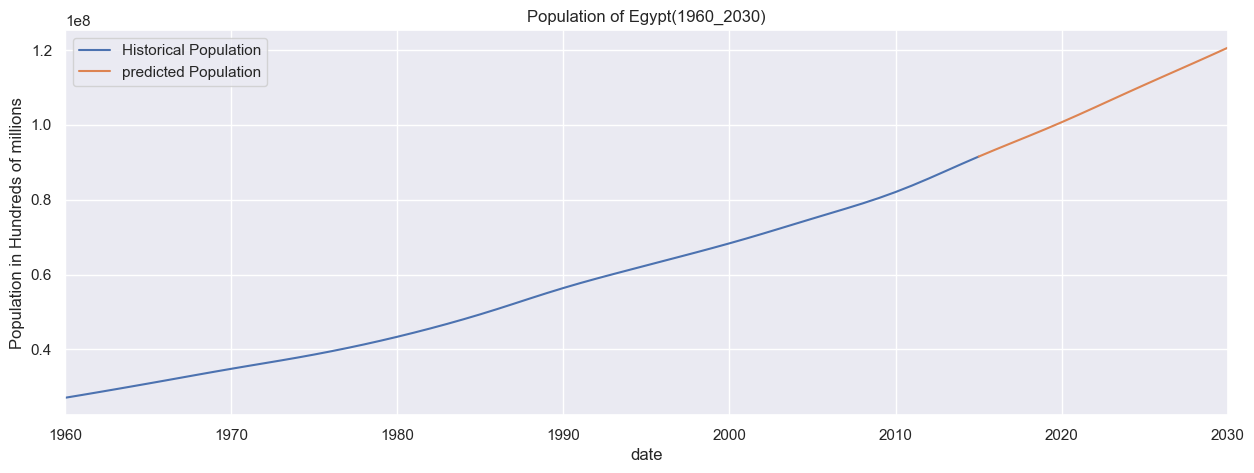

In [29]:
df.total_population.plot(label = "Historical Population",ylabel = "Population in Hundreds of millions")
df_predicted.total_population.plot(figsize = (15,5), label = "predicted Population")

plt.title("Population of Egypt(1960_2030)")

plt.legend()

### Pretty well, Let's Save our Results!

In [30]:
df_predicted.to_csv("datasets/Predictions.csv")